# Análisis Libre

## Alba Márquez-Rodríguez

Para realizar esta práctica se ha decidido escoger un conjunto de datos de la [UCI Machine Learning Repository](https://archive.ics.uci.edu/datasets).

Por interés personal en la temática del conjunto de datos se ha escogido uno de [Mushroom](https://archive.ics.uci.edu/dataset/73/mushroom). Que se compone de 8124 instancias y 22 características. Siendo la clasificación *booleana* entre comestible (edible) o no comestible / venenosa (poisonous) que en *booleano* sería representado e = 1 y p = 0.

Se propone realizar el análisis con 2 técnicas diferentes. En el repositorio viene descrita como una tarea de clasificación, pero se va a explorar los resultados obtenidos primero con un *clustering* y, si no son concluyentes, se realizará una clasificación.

In [40]:
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline

import pandas as pd

!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo # Dataset

# Represetnaciones Gráficas
import plotly.express as px
import plotly.graph_objects as go

from pyspark.sql.functions import when

# Clustering
from pyspark.ml.evaluation import ClusteringEvaluator

# Clasificación
from pyspark.ml.classification import RandomForestClassifier, NaiveBayes, LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

## Dependencias

In [1]:
# Instalacion de java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# Instalacion de spark
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# Descomprimimos el fichero de spark
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

# Instalamos findspark
!pip install -q findspark

# Establecemos las variables de entorno para Java y Spark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"

### Sesión Local de Spark

In [2]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

## Conjunto de Datos

Al tratarse de un trabajo ya realizado y saber el conjunto de datos con el que se va a trabajar, se van a importar directamente los datos de este conjunto de datos.

El código puede ser encontrado en la propia página de UCI para importarlo directamente en Python.

Aún así se ha modificado en cierto modo para poder convertirlo en un csv y luego utilizarlo con spark

In [3]:
mushroom = fetch_ucirepo(id=73)

# Accessing data
X = mushroom.data.features
y = mushroom.data.targets

# Creating a Pandas DataFrame
df = pd.DataFrame(data=X, columns=mushroom.feature_names)

# Adding the target variable to the DataFrame
df['target'] = y

# Saving the DataFrame to a CSV file
df.to_csv('mushroom_dataset.csv', index=False)


In [4]:
dataset = spark.read.csv('mushroom_dataset.csv',inferSchema=True, header =True)

In [5]:
dataset.printSchema()

root
 |-- cap-shape: string (nullable = true)
 |-- cap-surface: string (nullable = true)
 |-- cap-color: string (nullable = true)
 |-- bruises: string (nullable = true)
 |-- odor: string (nullable = true)
 |-- gill-attachment: string (nullable = true)
 |-- gill-spacing: string (nullable = true)
 |-- gill-size: string (nullable = true)
 |-- gill-color: string (nullable = true)
 |-- stalk-shape: string (nullable = true)
 |-- stalk-root: string (nullable = true)
 |-- stalk-surface-above-ring: string (nullable = true)
 |-- stalk-surface-below-ring: string (nullable = true)
 |-- stalk-color-above-ring: string (nullable = true)
 |-- stalk-color-below-ring: string (nullable = true)
 |-- veil-type: string (nullable = true)
 |-- veil-color: string (nullable = true)
 |-- ring-number: string (nullable = true)
 |-- ring-type: string (nullable = true)
 |-- spore-print-color: string (nullable = true)
 |-- population: string (nullable = true)
 |-- habitat: string (nullable = true)
 |-- target: string

Estas son las features que contiene el conjunto de datos:

In [6]:
dataset.columns

['cap-shape',
 'cap-surface',
 'cap-color',
 'bruises',
 'odor',
 'gill-attachment',
 'gill-spacing',
 'gill-size',
 'gill-color',
 'stalk-shape',
 'stalk-root',
 'stalk-surface-above-ring',
 'stalk-surface-below-ring',
 'stalk-color-above-ring',
 'stalk-color-below-ring',
 'veil-type',
 'veil-color',
 'ring-number',
 'ring-type',
 'spore-print-color',
 'population',
 'habitat',
 'target']

Para hacer el clustering se tomarán 3 de estas features, no se sabe cuál podría ser la elección óptima y esto conllevaría hacer un análisis más exhaustivo. Así que se va a comenzar seleccionando 3 aleatorias, por ejemplo, las que contienen información sobre el color:
- cap-color
- veil-color
- spore-print-color

Y se va a mostrar 20 de las instancias

In [7]:
subdataset = dataset.select("cap-color","veil-color","spore-print-color","target")
subdataset.printSchema()
subdataset.show()

root
 |-- cap-color: string (nullable = true)
 |-- veil-color: string (nullable = true)
 |-- spore-print-color: string (nullable = true)
 |-- target: string (nullable = true)

+---------+----------+-----------------+------+
|cap-color|veil-color|spore-print-color|target|
+---------+----------+-----------------+------+
|        n|         w|                k|     p|
|        y|         w|                n|     e|
|        w|         w|                n|     e|
|        w|         w|                k|     p|
|        g|         w|                n|     e|
|        y|         w|                k|     e|
|        w|         w|                k|     e|
|        w|         w|                n|     e|
|        w|         w|                k|     p|
|        y|         w|                k|     e|
|        y|         w|                n|     e|
|        y|         w|                k|     e|
|        y|         w|                n|     e|
|        w|         w|                n|     p|
|       

## Clustering

El clustering a realizr será con el algoritmo KMeans, hay que tener en cuenta que el conjunnto de datos contiene información categorica y esa es una de las razones por las que es más un problema de clasificación que de regresión. Se van a transformar estos valores categoricos en numéricos.

El resultado también será numérico (0 = poisonous, venenosa y 1 = edible, comestible)

### Experimento 1 (Features = Colores)

In [8]:
# Definir las columnas de características (variables que se utilizarán para el clustering)
feature_columns = ["cap-color", "veil-color", "spore-print-color"]

# Crear índices numéricos para las variables categóricas
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index", handleInvalid="keep") for col in feature_columns]

# Crear un ensamblador de características
assembler = VectorAssembler(inputCols=[col+"_index" for col in feature_columns], outputCol="features")

# Crear el modelo KMeans
kmeans = KMeans(k=2, seed=1)  # Puedes ajustar el valor de k según sea necesario

# Crear el pipeline con las etapas de índices, ensamblado y k-means
pipeline = Pipeline(stages=indexers + [assembler, kmeans])

# Ajustar el modelo al conjunto de datos
model = pipeline.fit(subdataset)

# Obtener los resultados del clustering
results = model.transform(subdataset)

# Mostrar los resultados
# results.select("cap-color", "veil-color", "spore-print-color", "target", "prediction").show()

# Sustituir los valores en la columna "prediction" por 'p' si es 0, y 'e' si es 1
results_with_labels = results.withColumn("prediction", when(results["prediction"] == 0, 'p').otherwise('e'))

# Mostrar los resultados con las etiquetas
# results_with_labels.select("cap-color", "veil-color", "spore-print-color", "target", "prediction").show()

#### Representaciones Gráficas

Si se muestra una representación gráfica 3D e interactiva se obtiene lo siguiente:

In [9]:
# Convertir las variables categóricas a números
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index_3d", handleInvalid="keep") for col in feature_columns]
assembler = VectorAssembler(inputCols=[col+"_index_3d" for col in feature_columns], outputCol="features_3d")
pipeline = Pipeline(stages=indexers + [assembler])
data_for_plot = pipeline.fit(subdataset).transform(subdataset)

# Obtener los resultados del clustering
results_for_plot = model.transform(data_for_plot)

# Mostrar el gráfico interactivo 3D
fig = px.scatter_3d(results_for_plot.toPandas(), x='cap-color_index_3d', y='veil-color_index_3d', z='spore-print-color_index_3d', color='prediction', opacity=0.7)
fig.show()


Con esto podemos ver aproximadamente como se han agrupado los cluters para las predicciones. Es importante tener en cuenta que no son predicciones sino agrupaciones de aquellas instancias más cercanas en cuanto a los valores de los parámetros.

Hay 8000 instancias pero sólo estamos teniendo en cuenta 3 features, por eso parece que hay muy pocas instancias representadas, porque se superponen aquellas que tienen el mismo valor en las 3 features. Además de que pueden estar superponiendose instancias con los mismos valores para las features seleccionadas pero con diferente valor de target. Este es el problema de intentar realizar clustering de un dataset con tantas features con tantas, hay que tener cuidado al realizar esta reducción de instancias.

Por otro lado, nos interesa saber cómo lo ha hecho respecto a los datos reales, a los targets. Por eso se han representado con una transparencia en verde aquellos que son edibles = comestibles (1) y en rojo los poisonous = venenosos (0).

In [10]:
# Convertir el DataFrame a Pandas para facilitar el trabajo con Plotly
pandas_results = results_for_plot.toPandas()

# Crear una figura 3D con Plotly
fig = go.Figure()

# Añadir puntos para las instancias predichas
fig.add_trace(go.Scatter3d(
    x=pandas_results['cap-color_index_3d'],
    y=pandas_results['veil-color_index_3d'],
    z=pandas_results['spore-print-color_index_3d'],
    mode='markers',
    marker=dict(
        size=5,
        color=pandas_results['prediction'],
        colorscale='Viridis',
        opacity=1,
    ),
    name='Predicted Clusters'
))

# Añadir circunferencias para las instancias reales con target 'e' (1)
fig.add_trace(go.Scatter3d(
    x=pandas_results[pandas_results['target'] == 'e']['cap-color_index_3d'],
    y=pandas_results[pandas_results['target'] == 'e']['veil-color_index_3d'],
    z=pandas_results[pandas_results['target'] == 'e']['spore-print-color_index_3d'],
    mode='markers',
    marker=dict(
        size=10,
        color='red',
        opacity=0.2,
        symbol='circle',
    ),
    name='Actual Target: e'
))

# Añadir circunferencias para las instancias reales con target 'p' (0)
fig.add_trace(go.Scatter3d(
    x=pandas_results[pandas_results['target'] == 'p']['cap-color_index_3d'],
    y=pandas_results[pandas_results['target'] == 'p']['veil-color_index_3d'],
    z=pandas_results[pandas_results['target'] == 'p']['spore-print-color_index_3d'],
    mode='markers',
    marker=dict(
        size=10,
        color='green',
        opacity=0.2,
        symbol='circle',
    ),
    name='Actual Target: p'
))

# Configurar el diseño del gráfico
fig.update_layout(scene=dict(
                    xaxis_title='Cap Color',
                    yaxis_title='Veil Color',
                    zaxis_title='Spore Print Color'))

# Mostrar el gráfico
fig.show()


De este gráfico se puede concluír que las agrupaciones siguen sin ser muy buenas y que además iba a ser complicado realizar clustering teniendo los datos tan con tan poca información, de 22 características se ha pasado a 3.

Por otro lado puede que el algoritmo de clustering K-means no sea el mejor pues las representaciones están todas muy cercanas, se podría probar cambiando hiperparámetros como, en el caso del algoritmo K-means el valor de K. Pero al haber representado los valores reales parece que sigue sin tener mucho sentido utilizar este tipo de técnicas para este problema.

Estos resultados son los esperados, y con esto se quería explorar por qué es tan importante saber cómo es nuestro problema y qué información tenemos de él para poder aplicar la técnica adecuada que nos ayude a resolverlo.

Se va a realizar un cálculo para evalúar las predicciones y se va a proceder a cambiar los parámetros seleccionados, para realizar una experimentación un poco más extendida del clustering y ver cómo influye la elección de las features.

### Experimento 2 (Features = Cap)

In [11]:
# Sustituir los valores en la columna "prediction" por 'p' si es 0, y 'e' si es 1
# results_numeric = results.withColumn("target", when(results["target"] == "p", 0).otherwise(1))

# Calcular el Silhouette Score
evaluator = ClusteringEvaluator()
silhouette_score = evaluator.evaluate(results)
print(f"Silhouette Score: {silhouette_score}")

Silhouette Score: 0.3667234220754826


Tal y como se podía intuír el score es bajo, es de un 36,67% que no llega ni al 50%, es decir, la predicción es aún peor que si se realizara al azar.

Como se ha adelantado antes, ahora se realizará con otras features, en vez de tomar solo aquellas basadas en el color se tomarán todas las que dan información sobre el cap de una seta, es decir, la parte superior de esta:

In [12]:
subdataset_cap = dataset.select("cap-shape","cap-surface","cap-color","target")
subdataset_cap.printSchema()
subdataset_cap.show()

root
 |-- cap-shape: string (nullable = true)
 |-- cap-surface: string (nullable = true)
 |-- cap-color: string (nullable = true)
 |-- target: string (nullable = true)

+---------+-----------+---------+------+
|cap-shape|cap-surface|cap-color|target|
+---------+-----------+---------+------+
|        x|          s|        n|     p|
|        x|          s|        y|     e|
|        b|          s|        w|     e|
|        x|          y|        w|     p|
|        x|          s|        g|     e|
|        x|          y|        y|     e|
|        b|          s|        w|     e|
|        b|          y|        w|     e|
|        x|          y|        w|     p|
|        b|          s|        y|     e|
|        x|          y|        y|     e|
|        x|          y|        y|     e|
|        b|          s|        y|     e|
|        x|          y|        w|     p|
|        x|          f|        n|     e|
|        s|          f|        g|     e|
|        f|          f|        w|     e|
|        x|

In [13]:
# Definir las columnas de características (variables que se utilizarán para el clustering)
feature_columns_cap = ["cap-shape", "cap-surface", "cap-color"]

# Crear índices numéricos para las variables categóricas
indexers_cap = [StringIndexer(inputCol=col, outputCol=col+"_index", handleInvalid="keep") for col in feature_columns_cap]

# Crear un ensamblador de características
assembler_cap = VectorAssembler(inputCols=[col+"_index" for col in feature_columns_cap], outputCol="features")

# Crear el modelo KMeans
kmeans_cap = KMeans(k=2, seed=1)  # Puedes ajustar el valor de k según sea necesario

# Crear el pipeline con las etapas de índices, ensamblado y k-means
pipeline_cap = Pipeline(stages=indexers_cap + [assembler_cap, kmeans_cap])

# Ajustar el modelo al conjunto de datos
model_cap = pipeline_cap.fit(subdataset_cap)

# Obtener los resultados del clustering
results_cap = model_cap.transform(subdataset_cap)

# Sustituir los valores en la columna "prediction" por 'p' si es 0, y 'e' si es 1
results_with_labels_cap = results_cap.withColumn("prediction", when(results_cap["prediction"] == 0, 'p').otherwise('e'))

# Mostrar los resultados con las etiquetas
results_with_labels_cap.select("cap-shape", "cap-surface", "cap-color", "target", "prediction").show()

+---------+-----------+---------+------+----------+
|cap-shape|cap-surface|cap-color|target|prediction|
+---------+-----------+---------+------+----------+
|        x|          s|        n|     p|         e|
|        x|          s|        y|     e|         p|
|        b|          s|        w|     e|         p|
|        x|          y|        w|     p|         p|
|        x|          s|        g|     e|         e|
|        x|          y|        y|     e|         p|
|        b|          s|        w|     e|         p|
|        b|          y|        w|     e|         p|
|        x|          y|        w|     p|         p|
|        b|          s|        y|     e|         p|
|        x|          y|        y|     e|         p|
|        x|          y|        y|     e|         p|
|        b|          s|        y|     e|         p|
|        x|          y|        w|     p|         p|
|        x|          f|        n|     e|         e|
|        s|          f|        g|     e|         e|
|        f| 

### Representaciones Gráficas

In [14]:
# Convertir las variables categóricas a números
indexers_cap_3d = [StringIndexer(inputCol=col, outputCol=col+"_index_3d", handleInvalid="keep") for col in feature_columns_cap]
assembler_cap_3d = VectorAssembler(inputCols=[col+"_index_3d" for col in feature_columns_cap], outputCol="features_3d")
pipeline_cap_3d = Pipeline(stages=indexers_cap_3d + [assembler_cap_3d])
data_for_plot_cap_3d = pipeline_cap_3d.fit(subdataset_cap).transform(subdataset_cap)

# Obtener los resultados del clustering
results_for_plot_cap_3d = model_cap.transform(data_for_plot_cap_3d)

# Mostrar el gráfico interactivo 3D
fig_cap_3d = px.scatter_3d(results_for_plot_cap_3d.toPandas(), x='cap-shape_index_3d', y='cap-surface_index_3d', z='cap-color_index_3d', color='prediction', opacity=0.2)
fig_cap_3d.show()

In [15]:
# Convertir el DataFrame a Pandas para facilitar el trabajo con Plotly
pandas_results_cap_3d = results_for_plot_cap_3d.toPandas()

# Crear una figura 3D con Plotly
fig_cap_3d = go.Figure()

# Añadir puntos para las instancias predichas
fig_cap_3d.add_trace(go.Scatter3d(
    x=pandas_results_cap_3d['cap-shape_index_3d'],
    y=pandas_results_cap_3d['cap-surface_index_3d'],
    z=pandas_results_cap_3d['cap-color_index_3d'],
    mode='markers',
    marker=dict(
        size=5,
        color=pandas_results_cap_3d['prediction'],
        colorscale='Viridis',
        opacity=1.0,
    ),
    name='Predicted Clusters'
))

# Añadir circunferencias para las instancias reales con target 'e' (1)
fig_cap_3d.add_trace(go.Scatter3d(
    x=pandas_results_cap_3d[pandas_results_cap_3d['target'] == 'e']['cap-shape_index_3d'],
    y=pandas_results_cap_3d[pandas_results_cap_3d['target'] == 'e']['cap-surface_index_3d'],
    z=pandas_results_cap_3d[pandas_results_cap_3d['target'] == 'e']['cap-color_index_3d'],
    mode='markers',
    marker=dict(
        size=10,
        color='red',
        opacity=0.2,
        symbol='circle',
    ),
    name='Actual Target: e'
))

# Añadir circunferencias para las instancias reales con target 'p' (0)
fig_cap_3d.add_trace(go.Scatter3d(
    x=pandas_results_cap_3d[pandas_results_cap_3d['target'] == 'p']['cap-shape_index_3d'],
    y=pandas_results_cap_3d[pandas_results_cap_3d['target'] == 'p']['cap-surface_index_3d'],
    z=pandas_results_cap_3d[pandas_results_cap_3d['target'] == 'p']['cap-color_index_3d'],
    mode='markers',
    marker=dict(
        size=10,
        color='green',
        opacity=0.2,
        symbol='circle',
    ),
    name='Actual Target: p'
))

# Configurar el diseño del gráfico
fig_cap_3d.update_layout(scene=dict(
                    xaxis_title='Cap Shape',
                    yaxis_title='Cap Surface',
                    zaxis_title='Cap Color'))

# Mostrar el gráfico
fig_cap_3d.show()


Podemos ver como sigue sin haber unas buenas "predicciones" y, además, en este caso se ve mucho mejor como en las circunferencias hay algunas de tonalidades marrones, esto quiere decir que hay instancias con los mismos valores para las features y sin embargo diferente valor para el target, lo que está dificultando la creación de clusters.

In [16]:
# Sustituir los valores en la columna "prediction" por 'p' si es 0, y 'e' si es 1
# results_numeric = results.withColumn("target", when(results["target"] == "p", 0).otherwise(1))

# Calcular el Silhouette Score
evaluator = ClusteringEvaluator()
silhouette_score = evaluator.evaluate(results_cap)
print(f"Silhouette Score: {silhouette_score}")

Silhouette Score: 0.6306407309614172


Sin embargo, en esta ocasión el valor de la evaluación ha subido considerablemente, llegando a superar el 50% que representaría una predicción al azar. Aún así, el valor sigue sin ser lo suficientemente bueno como para aceptarlo.

Para realizar este análisis si un 63% nos parece aceptable o no se debe estudiar bien el problema, en este caso estamos hablando de setas venenosas o comestibles, un error en la predicción de si una seta es comestible o venenosa podría conllevar la muerte por lo que se podría decir que se necesita un score mucho más alto para poder considerarlo aceptable.

Como ideas de mejora para las predicciones a través de clustering se propone agrupaciones de features. Por ejemplo, todas aquellas features que describen "cap" se podrían agrupar en una. Así si una seta tenía los valores x, s, y el valor para cap podría ser xsy. Esto crearía muchos nuevos valores, en total unos 3^3 = 27 valores diferentes para describir cap. Además que aún podríamos elegir otras 2 features para realizar el clustering. En estas otras 2 features se podría realizar una agrupación similar por lo que en total en lugar de estar teniendo en cuenta 3 features se podrían tener alrededor de 9 features.

Esto sería un experimento interesante para realizar pero tal y como se adelanto al inicio del análisis se va a proceder a realizar varias clasificaciones, que es para lo que el dataset estaba preparado inicialmente.


## Clasificación

Se va a realizar la clasificación con 3 algoritmos diferentes.
- Random Forest
- Naive Bayes
- SPV / One vs Rest

Es muy importante utilizar los mismos subconjuntos de entrenamiento y test para poder comparar los resultados.

### Conjunto de Datos

Para la clasificación se van a tener en cuenta todas las feature, además, al ser de tipo string deben convertirse a tipo entero.

In [44]:
# Definir las columnas de características y la columna objetivo
feature_columns = ['cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor', 'gill-attachment',
                   'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape', 'stalk-root',
                   'stalk-surface-above-ring', 'stalk-surface-below-ring', 'stalk-color-above-ring',
                   'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number', 'ring-type',
                   'spore-print-color', 'population', 'habitat']
target_column = 'target'

# Crear índices numéricos para las variables categóricas
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index", handleInvalid="keep") for col in feature_columns]

# Crear un ensamblador de características
assembler = VectorAssembler(inputCols=[col+"_index" for col in feature_columns], outputCol="features")

# Crear índice numérico para la columna de destino (target)
label_indexer = StringIndexer(inputCol=target_column, outputCol="label")

El conjunto de datos debe ser divido en clasificación tanto en train como en test. Que permanecerá así para todos los experimentos. La distribución que se va a realizar será de un 70-30.

In [45]:
# Dividir el conjunto de datos en entrenamiento y prueba
train_data, test_data = dataset.randomSplit([0.7, 0.3], seed=42)

### [Random Forest](https://spark.apache.org/docs/latest/ml-classification-regression.html#random-forest-classifier)

Random Forest es un algoritmo de aprendizaje automático que crea múltiples árboles de decisión y los combina para mejorar la precisión y la generalización del modelo. Cada árbol se entrena en una submuestra aleatoria del conjunto de datos, y las predicciones finales se obtienen mediante la votación o promedio de las predicciones individuales de los árboles. Este enfoque reduce el sobreajuste y mejora la robustez del modelo.

En este caso se realizará con el valor por defecto del número de árboles = 10.


In [33]:
# Crear el clasificador Random Forest
rf_classifier = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10)

# Crear el pipeline con las etapas de índices, ensamblado y clasificación
rf_pipeline = Pipeline(stages=indexers + [assembler, label_indexer, rf_classifier])

# Ajustar el modelo al conjunto de entrenamiento
rf_model = rf_pipeline.fit(train_data)

# Realizar predicciones en el conjunto de prueba
rf_predictions = rf_model.transform(test_data)

#Mostramos las predicciones
rf_predictions.select('target', 'prediction').show()

+------+----------+
|target|prediction|
+------+----------+
|     e|       0.0|
|     e|       0.0|
|     e|       0.0|
|     e|       0.0|
|     e|       0.0|
|     e|       0.0|
|     e|       0.0|
|     e|       0.0|
|     e|       0.0|
|     e|       0.0|
|     p|       1.0|
|     e|       0.0|
|     e|       0.0|
|     e|       0.0|
|     e|       0.0|
|     e|       0.0|
|     e|       0.0|
|     e|       0.0|
|     e|       0.0|
|     e|       0.0|
+------+----------+
only showing top 20 rows



In [70]:
print(rf_model.toDebugString)

AttributeError: ignored

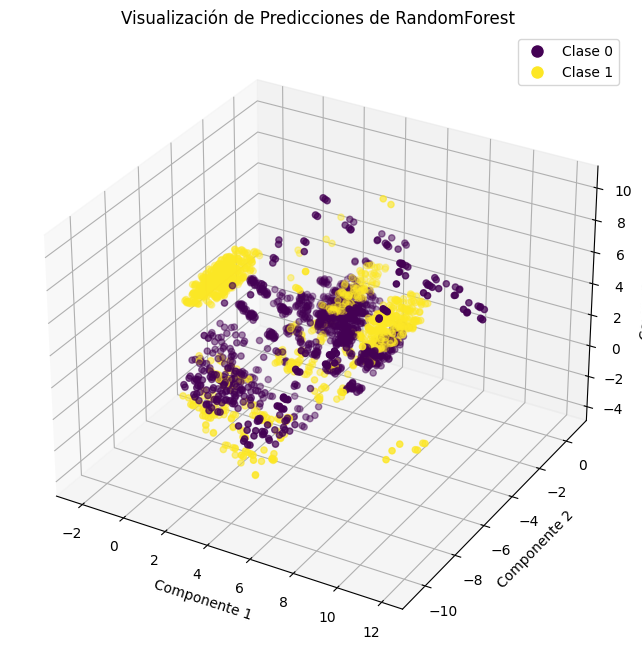

In [63]:
from mpl_toolkits.mplot3d import Axes3D

# Reducir la dimensionalidad a 3 componentes principales para visualización 3D
pca_3d = PCA(k=3, inputCol="features", outputCol="pca_features_3d")
pca_model_3d = pca_3d.fit(rf_predictions)
result_pca_3d = pca_model_3d.transform(rf_predictions)

# Convertir a Pandas para visualización local (asegúrate de que los datos caben en la memoria local)
result_pandas_3d = result_pca_3d.select("target", "prediction", "pca_features_3d").toPandas()

# Visualización en un gráfico de dispersión 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(result_pandas_3d['pca_features_3d'].apply(lambda x: x[0]),
                     result_pandas_3d['pca_features_3d'].apply(lambda x: x[1]),
                     result_pandas_3d['pca_features_3d'].apply(lambda x: x[2]),
                     c=result_pandas_3d['prediction'], cmap='viridis')

ax.set_title("Visualización de Predicciones de RandomForest")
ax.set_xlabel("Componente 1")
ax.set_ylabel("Componente 2")
ax.set_zlabel("Componente 3")

# Añadir una leyenda
legend_labels = {0: 'Clase 0', 1: 'Clase 1'}  # Ajusta según tus etiquetas de clase
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(label)),
                     markersize=10, label=legend_labels[label]) for label in result_pandas_3d['prediction'].unique()]
ax.legend(handles=handles)

plt.show()

En la muestra de predicciones podemos ver como el 0 representa aquellos valores como edible = comestible y poisonous = 1. Y que en todos los mostrados la predicción ha sido acertada.

Ahora se va a comprobar el accuracy como métrica para medir estas predicciones:

In [37]:
# Evaluar el rendimiento del modelo
rf_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
rf_accuracy = evaluator.evaluate(rf_predictions)

print("Test Error = %g" % (1.0 - rf_accuracy))
print("Test Accuracy = %g " % rf_accuracy)

Test Error = 0.00128425
Test Accuracy = 0.998716 


El valor es del 99.8% lo cuál es un valor bastante alto llegando a predecir casi con total perfección.

Esto podría ser por la elección de los subconjuntos de entrenamiento y test y se podrían llevar a cabo experimentos con otros subconjuntos y otras técnicas para realizar los subconjuntos. Pero la próxima experimentación consistirá en la aplicación de otro algoritmo.

### Naive Bayes


Naive Bayes es un algoritmo de clasificación que se basa en el teorema de Bayes y asume independencia condicional entre las características. Es eficiente y efectivo para datos de alta dimensionalidad.

Nuestro conjunto de datos tiene muchas características por lo que se espera que Naive Bayes tenga buenos resultados.

In [47]:
# Crear el clasificador Naive Bayes
nb_classifier = NaiveBayes(labelCol="label", featuresCol="features")

# Crear el pipeline con las etapas de índices, ensamblado y clasificación
nb_pipeline = Pipeline(stages=indexers + [assembler, label_indexer, nb_classifier])

# Ajustar el modelo al conjunto de entrenamiento
nb_model = nb_pipeline.fit(train_data)

# Realizar predicciones en el conjunto de prueba
nb_predictions = nb_model.transform(test_data)

# Mostrar las predicciones
nb_predictions.select('target', 'prediction').show()


+------+----------+
|target|prediction|
+------+----------+
|     e|       0.0|
|     e|       0.0|
|     e|       0.0|
|     e|       0.0|
|     e|       0.0|
|     e|       0.0|
|     e|       0.0|
|     e|       0.0|
|     e|       0.0|
|     e|       0.0|
|     p|       1.0|
|     e|       0.0|
|     e|       0.0|
|     e|       0.0|
|     e|       0.0|
|     e|       0.0|
|     e|       0.0|
|     e|       0.0|
|     e|       0.0|
|     e|       0.0|
+------+----------+
only showing top 20 rows



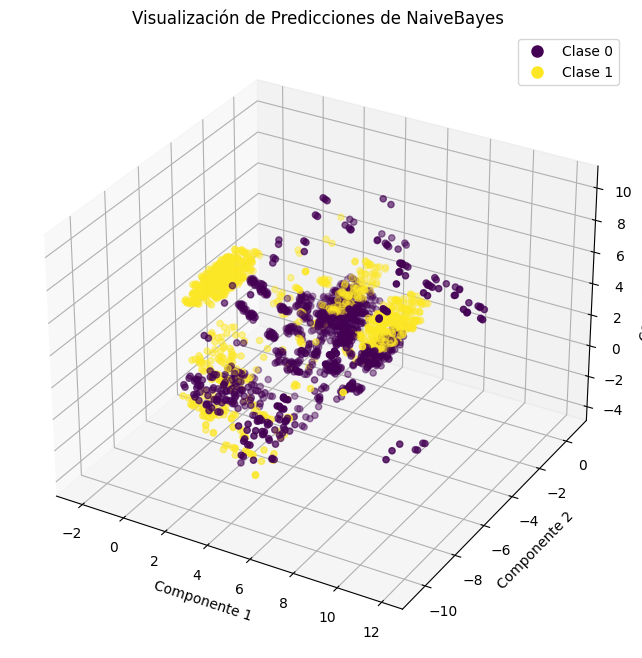

In [68]:
from mpl_toolkits.mplot3d import Axes3D

# Reducir la dimensionalidad a 3 componentes principales para visualización 3D
pca_3d = PCA(k=3, inputCol="features", outputCol="pca_features_3d")
pca_model_3d = pca_3d.fit(nb_predictions)
result_pca_3d = pca_model_3d.transform(nb_predictions)

# Convertir a Pandas para visualización local (asegúrate de que los datos caben en la memoria local)
result_pandas_3d = result_pca_3d.select("target", "prediction", "pca_features_3d").toPandas()

# Visualización en un gráfico de dispersión 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(result_pandas_3d['pca_features_3d'].apply(lambda x: x[0]),
                     result_pandas_3d['pca_features_3d'].apply(lambda x: x[1]),
                     result_pandas_3d['pca_features_3d'].apply(lambda x: x[2]),
                     c=result_pandas_3d['prediction'], cmap='viridis')

ax.set_title("Visualización de Predicciones de NaiveBayes")
ax.set_xlabel("Componente 1")
ax.set_ylabel("Componente 2")
ax.set_zlabel("Componente 3")

# Añadir una leyenda
legend_labels = {0: 'Clase 0', 1: 'Clase 1'}  # Ajusta según tus etiquetas de clase
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(label)),
                     markersize=10, label=legend_labels[label]) for label in result_pandas_3d['prediction'].unique()]
ax.legend(handles=handles)

plt.show()

In [48]:
# Evaluar el rendimiento del modelo
nb_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
nb_accuracy = evaluator.evaluate(nb_predictions)

print("Test Error = %g" % (1.0 - nb_accuracy))
print("Test Accuracy = %g " % nb_accuracy)

Test Error = 0.0920377
Test Accuracy = 0.907962 


Los resultados no mejoran los obtenidos con Random Forest aunque también son bastante buenos. El accuracy es del 90,7%

### SVM

Support Vector Machine (SVM) es un algoritmo de aprendizaje supervisado utilizado para problemas de clasificación y regresión. En el contexto de clasificación, SVM busca encontrar el hiperplano óptimo que mejor separa las instancias de diferentes clases en un espacio multidimensional. La idea es maximizar la distancia entre las instancias más cercanas de clases diferentes, llamadas vectores de soporte.

In [54]:
# Crear el clasificador Naive Bayes
svm_classifier = LinearSVC(labelCol="label", featuresCol="features")

# Crear el pipeline con las etapas de índices, ensamblado y clasificación
svm_pipeline = Pipeline(stages=indexers + [assembler, label_indexer, svm_classifier])

# Ajustar el modelo al conjunto de entrenamiento
svm_model = nb_pipeline.fit(train_data)

# Realizar predicciones en el conjunto de prueba
svm_predictions = svm_model.transform(test_data)

# Mostrar las predicciones
svm_predictions.select('target', 'prediction').show()

+------+----------+
|target|prediction|
+------+----------+
|     e|       0.0|
|     e|       0.0|
|     e|       0.0|
|     e|       0.0|
|     e|       0.0|
|     e|       0.0|
|     e|       0.0|
|     e|       0.0|
|     e|       0.0|
|     e|       0.0|
|     p|       1.0|
|     e|       0.0|
|     e|       0.0|
|     e|       0.0|
|     e|       0.0|
|     e|       0.0|
|     e|       0.0|
|     e|       0.0|
|     e|       0.0|
|     e|       0.0|
+------+----------+
only showing top 20 rows



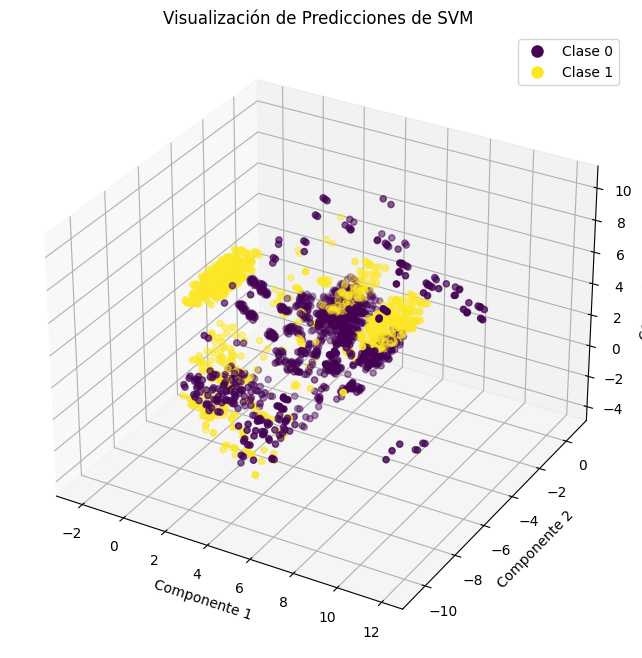

In [69]:
from mpl_toolkits.mplot3d import Axes3D

# Reducir la dimensionalidad a 3 componentes principales para visualización 3D
pca_3d = PCA(k=3, inputCol="features", outputCol="pca_features_3d")
pca_model_3d = pca_3d.fit(svm_predictions)
result_pca_3d = pca_model_3d.transform(svm_predictions)

# Convertir a Pandas para visualización local (asegúrate de que los datos caben en la memoria local)
result_pandas_3d = result_pca_3d.select("target", "prediction", "pca_features_3d").toPandas()

# Visualización en un gráfico de dispersión 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(result_pandas_3d['pca_features_3d'].apply(lambda x: x[0]),
                     result_pandas_3d['pca_features_3d'].apply(lambda x: x[1]),
                     result_pandas_3d['pca_features_3d'].apply(lambda x: x[2]),
                     c=result_pandas_3d['prediction'], cmap='viridis')

ax.set_title("Visualización de Predicciones de SVM")
ax.set_xlabel("Componente 1")
ax.set_ylabel("Componente 2")
ax.set_zlabel("Componente 3")

# Añadir una leyenda
legend_labels = {0: 'Clase 0', 1: 'Clase 1'}  # Ajusta según tus etiquetas de clase
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(label)),
                     markersize=10, label=legend_labels[label]) for label in result_pandas_3d['prediction'].unique()]
ax.legend(handles=handles)

plt.show()

In [55]:
# Evaluar el rendimiento del modelo
svm_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
svm_accuracy = evaluator.evaluate(svm_predictions)

print("Test Error = %g" % (1.0 - svm_accuracy))
print("Test Accuracy = %g " % svm_accuracy)

Test Error = 0.0920377
Test Accuracy = 0.907962 


En este caso el accuracy obtenido es muy similar al obtenido por el algoritmo Naive Bayes, en teoría tienen enfoques y funcionamientos diferentes, pero sin embargo han conseguido el mismo accuracy, lo que es llamativo pero no tiene porque decir nada.